In [1]:
import h5py
import hdf5_interface
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, Legend
import requests
from bokeh.palettes import Spectral4


In [2]:
my_file = h5py.File("solar_panel_data_alaska.h5", 'r')

In [3]:
def hdf5_to_dataframe(hdf5_filename, location_name, panel_name):
    """This function extracts data from an HDF5 file and loads it into a pandas dataframe"""
    #Load the HDF5 file data
    hdf5_file = h5py.File('{}.h5'.format(hdf5_filename), 'r')
    hdf5_location = hdf5_file.get(location_name)
    panel_location = hdf5_location.get(panel_name)
    dataframe = pd.DataFrame()
    for keys in panel_location.keys():
        dataframe[str(keys)] = panel_location[str(keys)]
    dataframe['Month'] = dataframe['Month'].astype(int)
    return dataframe

In [4]:
coordinate = pd.DataFrame(columns=['location','latitude','longitude'])
coordinate['location']=['Ambler-Shungnak-Kobuk','Anchorage','Bethel','Chickaloon',
                        'Deering','Denali Park','Fairbanks','Fort Yukon',
                        'Galena-Koyukuk-Ruby', 'Homer','Naknek','Noatak',
                        'Noorvik','Soldotna','Valdez','Wasilla-Palmer']

coordinate['latitude']=[66.995834, 61.193625, 60.794938, 61.823570, 
                        66.069413, 63.537277, 64.838033, 66.571563,
                        64.782991, 59.652521, 58.728349, 67.570921, 
                        66.836039, 60.486370, 61.128663, 61.582242]


coordinate['longitude']=[ -157.377096, -149.694974, -161.770716, -148.450442,
                         -162.766760,  -150.985453, -147.668970,  -145.250173,
                         -156.744933, -151.536496, -157.017444, -162.967490,
                          -161.041913, -151.060702, -146.353366, -149.441001]


coordinate

,location,latitude,longitude
0,Ambler-Shungnak-Kobuk,66.995834,-157.377096
1,Anchorage,61.193625,-149.694974
2,Bethel,60.794938,-161.770716
3,Chickaloon,61.823570,-148.450442
4,Deering,66.069413,-162.766760
5,Denali Park,63.537277,-150.985453
6,Fairbanks,64.838033,-147.668970
7,Fort Yukon,66.571563,-145.250173
8,Galena-Koyukuk-Ruby,64.782991,-156.744933
9,Homer,59.652521,-151.536496


In [5]:
def pvwatts_tmy2(lattitude,longitude):
    # Get the data from the PV Watts --TMY2
    list_parameters = {"formt": 'JSON', "api_key": "spJFj2l5ghY5jwk7dNfVYs3JHbpR6BOGHQNO8Y9Z", "system_capacity": 18, "module_type": 0, "losses": 14.08,
                  "array_type": 0, "tilt": 50, "azimuth": 180, "lat": lattitude, "lon": longitude, "dataset": 'tmy2'}
    json_response = requests.get("https://developer.nrel.gov/api/pvwatts/v6", params = list_parameters).json()
    TMY2 = pd.DataFrame(data = json_response['outputs'])
    return TMY2

def pvwatts_tmy3(lattitude,longitude):
    # Get the data from the PV Watts --TMY3
    list_parameters = {"formt": 'JSON', "api_key": "spJFj2l5ghY5jwk7dNfVYs3JHbpR6BOGHQNO8Y9Z", "system_capacity": 18, "module_type": 0, "losses": 14.08,
                  "array_type": 0, "tilt": 50, "azimuth": 180, "lat": lattitude, "lon": longitude, "dataset": 'tmy3'}
    json_response = requests.get("https://developer.nrel.gov/api/pvwatts/v6", params = list_parameters).json()
    TMY3 = pd.DataFrame(data = json_response['outputs'])
    return TMY3

In [9]:
print(pvwatts_tmy3(64.838033, -147.668970)/18)
print(pvwatts_tmy2(64.838033, -147.668970)/18)

    ac_monthly  poa_monthly  solrad_monthly  dc_monthly    ac_annual  \
0    16.634684     0.981350        0.031656   17.761698  1025.222548   
1    52.129062     3.159939        0.112855   54.633796  1025.222548   
2   110.153293     7.033841        0.226898  115.394436  1025.222548   
3   151.735135    10.229424        0.340981  158.682739  1025.222548   
4   145.448310    10.117905        0.326384  152.403754  1025.222548   
5   134.437527     9.514152        0.317138  141.216878  1025.222548   
6   128.052612     9.163098        0.295584  134.540690  1025.222548   
7   117.295573     8.304144        0.267876  123.039198  1025.222548   
8    81.833910     5.549301        0.184977   85.952969  1025.222548   
9    56.095323     3.551892        0.114577   59.015150  1025.222548   
10   27.249708     1.630693        0.054356   28.873277  1025.222548   
11    4.157370     0.253884        0.008190    4.743176  1025.222548   

    solrad_annual  capacity_factor  
0        0.190123         

In [9]:
def annual_Norm(dataframe,capacity):
    '''Calculate rolling annual production'''
    lenth_list = list(range(12,len(dataframe.index)))
    annual_values = []
    month = []
    for i in range(len(lenth_list)):
        single_values = dataframe['Energy'][lenth_list[i]-12:lenth_list[i]].sum()/capacity
        #rolling_average.append(each_period)
        single_month = dataframe['Date'][lenth_list[i]]
        annual_values.append(single_values)
        month.append(single_month)
    return(annual_values,month)

In [8]:
def daily_to_monthly_energy(file_name, location_name, panel_name):
    solar_dataframe = hdf5_to_dataframe(file_name, location_name, panel_name)
    new_dataframe = pd.DataFrame(columns = ['Year', 'Month', 'Energy', 'Interpolate'])
    previous_month_tracker = solar_dataframe['Month'][0]
    Sum = 0
    interpolated = 0
    j = 0 
    year_array = np.array(np.NaN)
    month_array = np.array(np.NaN)
    interpolation_array = np.array(np.NaN)
    energy_array = np.array(np.NaN)
    for i in range(len(solar_dataframe.index)):
        if solar_dataframe['Month'][i] == previous_month_tracker:
            Sum = Sum + solar_dataframe['Energy'][i]
            interpolated = interpolated + solar_dataframe['Interpolate'][i]
        else:
            year_array = np.append(year_array, solar_dataframe['Year'][i])
            month_array = np.append(month_array, solar_dataframe['Month'][i])
            if interpolated > 0:
                interpolation_array = np.append(interpolation_array, 1)
            else:
                interpolation_array = np.append(interpolation_array, 0)
            energy_array = np.append(energy_array, Sum)
            Sum = 0
            interpolated = 0
            j = j + 1
            previous_month_tracker = solar_dataframe['Month'][i]
    new_dataframe['Energy'] = energy_array.astype(int)
    new_dataframe['Month'] = month_array.astype(int)
    new_dataframe['Year'] = year_array.astype(int)
    new_dataframe['Interpolate'] = interpolation_array.astype(int)
    new_dataframe = new_dataframe.drop(0).reset_index(drop=True)
    
    #new_dataframe['DC Capacity'][1] = solar_dataframe['DC Capacity'][0]
    #new_dataframe['Location'][1] = solar_dataframe['Location'][0]
    return new_dataframe

# Calculate monthly production

In [20]:
#fairbanks = my_file.get('Fairbanks')
location=pd.DataFrame(columns=['Month', 'Year'])

location_name = 'Anchorage'    
location_hdf5 = my_file.get(location_name)

a=0
for name in location_hdf5:
    capacity = location_hdf5[name].attrs.__getitem__("DC Capacity")
    if location_hdf5[name].keys().__contains__('Day'):
        base = daily_to_monthly_energy('solar_panel_data_alaska', location_name, name)
        base = base.drop('Interpolate', axis=1)
    else:    
        base = hdf5_to_dataframe('solar_panel_data_alaska',location_name, name )
        base = base.drop('Interpolate', axis=1)
# read data
        
        
    base['Energy'] = base['Energy']/capacity
    location = pd.merge(location, base, on = ['Month', 'Year'], how='outer',suffixes=(a, a+1))
    a = a+1
    
# set up a dataframe to store TMY2&3 ac_monthly
pv = pd.DataFrame()
pv['TMY2'] = pvwatts_tmy2(61.193625,-149.694974).ac_monthly
pv['TMY3'] =pvwatts_tmy3(61.193625,-149.694974).ac_monthly
pv['Month'] = [1,2,3,4,5,6,7,8,9,10,11,12]

result = pd.merge(location, pv, on = ['Month'], how='outer' )
#merge PVWatts data into location data


result['Date'] = ""
# Change the date into a datetime format
for i in range(len(result)):
    result['Date'][i] = str(result['Year'][i]) + '-' + str(result['Month'][i])    
    result['Date'] = pd.to_datetime(result['Date'])


result = result.sort_values(by='Date')
# sort by date

result

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Energy1,Month,Year,Energy2,Energy3,Energy4,Energy5,Energy6,Energy7,Energy8,...,Energy22,Energy23,Energy24,Energy25,Energy26,Energy27,Energy28,TMY2,TMY3,Date
36,NaN,6,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2195.199219,2684.501465,2016-06-01
0,8.254464,7,2016,NaN,14.981982,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,120.756303,NaN,NaN,NaN,NaN,2129.129639,2111.834473,2016-07-01
3,46.796875,8,2016,NaN,51.477477,0.236607,NaN,NaN,NaN,NaN,...,NaN,NaN,132.605042,NaN,NaN,NaN,NaN,1757.272949,1928.262817,2016-08-01
6,35.546875,9,2016,5.371094,43.369369,46.004464,NaN,NaN,NaN,NaN,...,NaN,NaN,100.252101,NaN,NaN,NaN,NaN,1462.243408,1659.020874,2016-09-01
9,19.676339,10,2016,60.125000,25.063063,31.486607,NaN,NaN,NaN,NaN,...,NaN,NaN,88.907563,NaN,NaN,NaN,NaN,863.675903,1064.431641,2016-10-01
12,4.263393,11,2016,20.644531,5.948949,8.267857,0.386889,NaN,NaN,NaN,...,NaN,NaN,78.571429,NaN,NaN,NaN,NaN,613.279175,393.574005,2016-11-01
15,0.000000,12,2016,0.799258,0.070991,0.000000,1.437082,NaN,NaN,NaN,...,NaN,NaN,32.436975,NaN,NaN,NaN,NaN,273.084076,200.763565,2016-12-01
18,0.000000,1,2017,7.480195,1.180721,0.852812,4.820784,NaN,NaN,NaN,...,NaN,NaN,13.529412,NaN,NaN,NaN,NaN,385.944214,278.075134,2017-01-01
21,7.691964,2,2017,16.531250,9.093093,1.081295,18.571427,NaN,NaN,NaN,...,NaN,NaN,19.159664,NaN,NaN,NaN,NaN,888.520996,527.889526,2017-02-01
24,46.863839,3,2017,134.160156,58.432432,61.614955,98.487147,NaN,NaN,NaN,...,NaN,0.000000,19.159664,NaN,NaN,NaN,NaN,1710.003540,1565.585449,2017-03-01


In [21]:
xaxis=result['Date']  
# setting x axis with Date

tmy2 = result['TMY2']/18
tmy3 = result['TMY3']/18
# store tmy2&3 data


result = result.drop(['Date', 'Month', 'Year', 'TMY2', 'TMY3'], axis=1)
# delet Date column to calculate median value and maxium value

result['Median'] = result.median(1)
result["Max"] = result.max(1)
# adding median and max value into dataframe
result

,Energy1,Energy2,Energy3,Energy4,Energy5,Energy6,Energy7,Energy8,Energy9,Energy10,...,Energy21,Energy22,Energy23,Energy24,Energy25,Energy26,Energy27,Energy28,Median,Max
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
0,8.254464,NaN,14.981982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,120.756303,NaN,NaN,NaN,NaN,14.981982,120.756303
3,46.796875,NaN,51.477477,0.236607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,132.605042,NaN,NaN,NaN,NaN,49.137176,132.605042
6,35.546875,5.371094,43.369369,46.004464,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.252101,NaN,NaN,NaN,NaN,43.369369,100.252101
9,19.676339,60.125000,25.063063,31.486607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,88.907563,NaN,NaN,NaN,NaN,31.486607,88.907563
12,4.263393,20.644531,5.948949,8.267857,0.386889,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,78.571429,NaN,NaN,NaN,NaN,7.108403,78.571429
15,0.000000,0.799258,0.070991,0.000000,1.437082,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,32.436975,NaN,NaN,NaN,NaN,0.435124,32.436975
18,0.000000,7.480195,1.180721,0.852812,4.820784,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.529412,NaN,NaN,NaN,NaN,3.000752,13.529412
21,7.691964,16.531250,9.093093,1.081295,18.571427,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.159664,NaN,NaN,NaN,NaN,12.812172,19.159664
24,46.863839,134.160156,58.432432,61.614955,98.487147,NaN,NaN,NaN,NaN,4.955665,...,NaN,NaN,0.000000,19.159664,NaN,NaN,NaN,NaN,52.648136,134.160156


In [22]:
# plot median and max value vs. date
output_notebook()
p = figure(plot_width=600, plot_height=300, x_axis_type='datetime')

output_file("monthly_"+location_name+".html") 

# title style
p.title.text='The Solar Production in '+location_name
p.title.align = 'left'
p.title.text_font_size = "25px"

# add the number of panels in the figure
citation = Label(x=10, y=180, x_units='screen', y_units='screen',
                 text= str(len(location_hdf5)) + ' panels here', render_mode='css')
                 #border_line_color='black', border_line_alpha=1.0,
                 #background_fill_color='white', background_fill_alpha=1.0)
p.add_layout(citation)






r0 = p.line(xaxis, result['Max'], line_width=1, color='red')      #Best
r1 = p.line(xaxis, result['Median'], line_width=1, color='blue')  #Median
r2 = p.line(xaxis, tmy2, line_width=1, color='green')          #TMY2
r3 = p.line(xaxis, tmy3, line_width=1, color='orange')         #TMY3

    
    #add legend outside of figure
legend = Legend(items=[
("Best"   , [r0]),
("Median" , [r1]),
("TMY2" , [r2]),
("TMY3" , [r3]),
], location="center")
p.add_layout(legend, 'right')

# add labels
p.xaxis.axis_label = 'Month'
p.yaxis.axis_label = 'Monthly Production(kWh)'
p.legend.click_policy="hide"
show(p)

Loading BokehJS ...

 # Calculate normalized annual production

In [23]:
def popup(location_name,lattitude,longitude):
    '''read the data from 'solar_panel_data_alaska' file, 
       and generate the figure with TMY2&3 and median/max lines
    
    input: location_name, lattitude, longitude
    output: Normalized Annual Production figure and generate a html file named "popup_"+location_name+".html"  
    '''
    location_hdf5 = my_file.get(location_name)
    location=pd.DataFrame(columns=['Date'])
    a=0
    for name in location_hdf5:
        capacity = location_hdf5[name].attrs.__getitem__("DC Capacity")
        if location_hdf5[name].keys().__contains__('Day'):
            base = daily_to_monthly_energy('solar_panel_data_alaska', location_name, name)
        else:    
            base = hdf5_to_dataframe('solar_panel_data_alaska',location_name, name )
        # read data
        


        # Change the date into a datetime format
        base['Date']= ""
        for i in range(len(base)):
            base['Date'][i] = str(base['Year'][i]) + '-' + str(base['Month'][i])    
            base['Date'] = pd.to_datetime(base['Date'])
        base.drop(['Year','Month'],axis = 1,inplace = True)

        # calculate annual value
        annual_values,month= annual_Norm(base,capacity)
        new_base = pd.DataFrame({'Date':month,'Annual':annual_values})

        location = pd.merge(location, new_base, on = ['Date'], how='outer',suffixes=(a, a+1))
        a = a+1

    location = location.sort_values(by='Date')

    xaxis=location['Date']  
    # setting x axis with Date

    tmy2 = pvwatts_tmy2(lattitude,longitude)['ac_annual'][1]/18
    tmy3 = pvwatts_tmy3(lattitude,longitude)['ac_annual'][1]/18
    # store tmy2&3 data


    location = location.drop(['Date'], axis=1)
    # delet Date column to calculate median value and maxium value

    location['Median'] = location.median(1)
    location["Max"] = location.max(1)
    location['Mean']=location.mean(1)
    # adding median and max value into dataframe


    # plot median and max value vs. date
    output_notebook()
    p = figure(plot_width=600, plot_height=300, x_axis_type='datetime')

    output_file("popup_"+location_name+".html")

    # title style
    p.title.text='Normalized Annual Production in '+location_name
    p.title.align = 'left'
    p.title.text_font_size = "25px"

    # add the number of panels in the figure
    citation = Label(x=10, y=180, x_units='screen', y_units='screen',
                     text= str(len(location_hdf5)) + ' panels here', render_mode='css')
                     #border_line_color='black', border_line_alpha=1.0,
                     #background_fill_color='white', background_fill_alpha=1.0)
    p.add_layout(citation)

    # draw lines    
    r0 = p.line(xaxis, location['Max'], line_width=1, color='red')      #Best
    r1 = p.line(xaxis, location['Median'], line_width=1, color='blue')  #Median
    r6= p.line(xaxis, location['Mean'], line_width=1, color='black')
    r2 = p.line(xaxis, tmy2*0.95, line_width=1, color='green')          #TMY2_low
    r3 = p.line(xaxis, tmy2*1.05, line_width=1, color='green')          #TMY2_high
    r4 = p.line(xaxis, tmy3*0.95, line_width=1, color='orange')         #TMY3_low
    r5 = p.line(xaxis, tmy3*1.05, line_width=1, color='orange')         #TMY3_high
    
    #add legend outside of figure
    legend = Legend(items=[
    ("Best"   , [r0]),
    ("Median" , [r1]),
    ("TMY2_low" , [r2]),
    ("TMY2_high" , [r3]),
    ("TMY3_low" , [r4]),
    ("TMY3_high" , [r5]),
    ('Mean',[r6])
    ], location="center")
    p.add_layout(legend, 'right')
    

    # add labels
    p.xaxis.axis_label = 'Month'
    p.yaxis.axis_label = 'Normalized Annual Production(kWh)'
    p.legend.click_policy="hide"
    show(p)

In [25]:
popup('Anchorage',61.193625,-149.694974 )

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

In [14]:
def popup2(location_name,lattitude,longitude):
    '''read the data from 'solar_panel_data_alaska' file, 
       and generate the figure with only TMY2 and median/max lines
    
    input: location_name, lattitude, longitude
    output: Normalized Annual Production figure and generate a html file named "popup_"+location_name+".html"  
    '''
    location_hdf5 = my_file.get(location_name)
    location=pd.DataFrame(columns=['Date'])
    a=0
    for name in location_hdf5:
        capacity = location_hdf5[name].attrs.__getitem__("DC Capacity")
        if location_hdf5[name].keys().__contains__('Day'):
            base = daily_to_monthly_energy('solar_panel_data_alaska', location_name, name)
        else:    
            base = hdf5_to_dataframe('solar_panel_data_alaska',location_name, name )
        # read data
        


        # Change the date into a datetime format
        base['Date']= ""
        for i in range(len(base)):
            base['Date'][i] = str(base['Year'][i]) + '-' + str(base['Month'][i])    
            base['Date'] = pd.to_datetime(base['Date'])
        base.drop(['Year','Month'],axis = 1,inplace = True)

        # calculate annual value
        annual_values,month= annual_Norm(base,capacity)
        new_base = pd.DataFrame({'Date':month,'Annual':annual_values})

        location = pd.merge(location, new_base, on = ['Date'], how='outer',suffixes=(a, a+1))
        a = a+1

    location = location.sort_values(by='Date')

    xaxis=location['Date']  
    # setting x axis with Date

    #tmy2 = pvwatts_tmy2(lattitude,longitude)['ac_annual'][1]/18
    tmy3 = pvwatts_tmy3(lattitude,longitude)['ac_annual'][1]/18
    # store tmy2&3 data


    location = location.drop(['Date'], axis=1)
    # delet Date column to calculate median value and maxium value

    location['Median'] = location.median(1)
    location["Max"] = location.max(1)
    # adding median and max value into dataframe


    # plot median and max value vs. date
    output_notebook()
    p = figure(plot_width=600, plot_height=300, x_axis_type='datetime')

    output_file("popup_"+location_name+".html")

    # title style
    p.title.text='Normalized Annual Production in '+location_name
    p.title.align = 'left'
    p.title.text_font_size = "25px"

    # add the number of panels in the figure
    citation = Label(x=10, y=180, x_units='screen', y_units='screen',
                     text= str(len(location_hdf5)) + ' panels here', render_mode='css')
                     #border_line_color='black', border_line_alpha=1.0,
                     #background_fill_color='white', background_fill_alpha=1.0)
    p.add_layout(citation)

    # draw lines    
    r0 = p.line(xaxis, location['Max'], line_width=1, color='red')      #Best
    r1 = p.line(xaxis, location['Median'], line_width=1, color='blue')  #Median
    #r2 = p.line(xaxis, tmy2*0.95, line_width=1, color='green')          #TMY2_low
    #r3 = p.line(xaxis, tmy2*1.05, line_width=1, color='green')          #TMY2_high
    r4 = p.line(xaxis, tmy3*0.95, line_width=1, color='orange')         #TMY3_low
    r5 = p.line(xaxis, tmy3*1.05, line_width=1, color='orange')         #TMY3_high
    
    #add legend outside of figure
    legend = Legend(items=[
    ("Best"   , [r0]),
    ("Median" , [r1]),
    #("TMY2_low" , [r2]),
    #("TMY2_high" , [r3]),
    ("TMY3_low" , [r4]),
    ("TMY3_high" , [r5]),
    ], location="center")
    p.add_layout(legend, 'right')
    

    # add labels
    p.xaxis.axis_label = 'Month'
    p.yaxis.axis_label = 'Normalized Annual Production(kWh)'
    p.legend.click_policy="hide"
    show(p)

In [18]:
three={0,7,8,9}
# location only contain TMY3 data
for i in three:
    popup2(coordinate['location'][i],coordinate['latitude'][i],coordinate['longitude'][i])



C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

In [15]:
twothree = {1,2,3,4,5,6,10,11,12,13,14,15}
# location contain TMY2 and TMY3 data
for i in twothree:
    popup(coordinate['location'][i],coordinate['latitude'][i],coordinate['longitude'][i])

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Loading BokehJS ...

In [11]:

location_name = 'Fairbanks'
location_hdf5 = my_file.get(location_name)
location=pd.DataFrame(columns=['Date'])

a=0
for name in location_hdf5:
    capacity = location_hdf5[name].attrs.__getitem__("DC Capacity")
    if location_hdf5[name].keys().__contains__('Day'):
        base = daily_to_monthly_energy('solar_panel_data_alaska', location_name, name)
    else:    
        base = hdf5_to_dataframe('solar_panel_data_alaska',location_name, name )
        # read data
        


    # Change the date into a datetime format
    base['Date']= ""
    for i in range(len(base)):
        base['Date'][i] = str(base['Year'][i]) + '-' + str(base['Month'][i])    
        base['Date'] = pd.to_datetime(base['Date'])
    base.drop(['Year','Month'],axis = 1,inplace = True)

    # calculate annual value
    annual_values,month= annual_Norm(base,capacity)
    new_base = pd.DataFrame({'Date':month,'Annual':annual_values})

    location = pd.merge(location, new_base, on = ['Date'], how='outer',suffixes=(a, a+1))
    a = a+1

location = location.sort_values(by='Date')

xaxis=location['Date']  
# setting x axis with Date




#location = location.drop(['Date'], axis=1)
location
# delet Date column to calculate median value and maxium value

#location['Median'] = location.median(1)
#location["Max"] = location.max(1)
# adding median and max value into dataframe

C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Annual1,Annual2,Annual3,Annual4,Annual5,Annual6,Annual7,Annual8,Annual9,...,Annual11,Annual12,Annual13,Annual14,Annual15,Annual16,Annual17,Annual18,Annual19,Annual20
46,2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,679.035088,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2011-11-01,NaN,NaN,NaN,NaN,NaN,NaN,700.487719,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,701.610526,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,701.445614,NaN,NaN,...,NaN,NaN,NaN,1089.194318,NaN,NaN,NaN,NaN,NaN,NaN
50,2012-02-01,NaN,NaN,NaN,NaN,NaN,NaN,696.663158,NaN,NaN,...,NaN,NaN,NaN,1095.051818,NaN,NaN,NaN,NaN,NaN,NaN
51,2012-03-01,NaN,NaN,NaN,NaN,NaN,NaN,694.356140,NaN,NaN,...,NaN,NaN,NaN,1093.367500,NaN,NaN,NaN,NaN,NaN,NaN
52,2012-04-01,NaN,NaN,NaN,NaN,NaN,NaN,662.954386,NaN,NaN,...,NaN,NaN,NaN,1032.012727,NaN,NaN,NaN,NaN,NaN,NaN
53,2012-05-01,NaN,NaN,NaN,NaN,NaN,NaN,667.708772,NaN,NaN,...,NaN,NaN,NaN,1035.561364,NaN,1109.704643,NaN,NaN,NaN,NaN
54,2012-06-01,NaN,NaN,NaN,NaN,NaN,NaN,652.491228,NaN,NaN,...,NaN,NaN,NaN,1015.326591,NaN,1236.757143,NaN,NaN,NaN,NaN
55,2012-07-01,NaN,NaN,NaN,NaN,NaN,NaN,658.275439,NaN,NaN,...,NaN,NaN,NaN,1015.327045,NaN,1254.976429,NaN,NaN,NaN,NaN


C:\Users\pengz\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


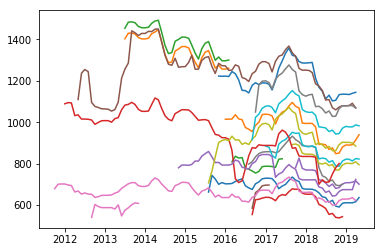

In [12]:
 for i in range(1,21):
        plt.plot(xaxis,location['Annual'+str(i)])